# Challenge Part 0: Data exploration

In [1]:
import pandas as pd
import numpy as np
import re

In this part I just explore the data to understand better its properties and distribution, experiment with some ideas for text pre-processing, and use a number of "classic" ML methods to obtain a baseline for the classifier.

In [2]:
# Read data from the CSV file
INPUT_PATH = 'twitter-airline-sentiment/Tweets.csv'
raw_data = pd.read_csv(INPUT_PATH, header=0)

df = raw_data.copy()[['text', 'airline_sentiment']]
df = df.rename(columns={'airline_sentiment': 'sentiment'})

print("DATA SIZE: " + str(df.shape))
df.head()

DATA SIZE: (14640, 2)


,text,sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


In [3]:
df.groupby('sentiment').count()

,text
sentiment,
negative,9178
neutral,3099
positive,2363


We see that the dataset has 14640 tweets, of which the big majority (9178) are negative, 2363 are positive and there are some neutrals. We also see that are many Twitter handlers, which normally refer to entities. Let's check them:

In [4]:
# let's find the handlers
from collections import Counter
from nltk.tokenize.casual import TweetTokenizer

def get_text_sequence(_df):
    return (row.text for _, row in _df.iterrows())

def get_all_handlers(text_it):
    handler_counts = Counter()

    tokenizer = TweetTokenizer(preserve_case=False)
    
    for text in text_it:
        tokens = tokenizer.tokenize(text)
        handler_counts.update(t for t in tokens if len(t) > 1 and t.startswith('@'))

    return handler_counts

handler_counts = get_all_handlers(get_text_sequence(df))
num_handlers_more_1 = sum(1 if c > 1 else 0 for c in handler_counts.values())
print("Number of handlers = %d, with more than 1 occurrence = %d" % (len(handler_counts), num_handlers_more_1))
handler_counts.most_common(20)

Number of handlers = 889, with more than 1 occurrence = 193


[('@united', 3893),
 ('@usairways', 2998),
 ('@americanair', 2961),
 ('@southwestair', 2458),
 ('@jetblue', 2248),
 ('@virginamerica', 518),
 ('@delta', 68),
 ('@imaginedragons', 45),
 ('@phlairport', 20),
 ('@dfwairport', 17),
 ('@wsj', 13),
 ('@ladygaga', 12),
 ('@carrieunderwood', 12),
 ('@fortunemagazine', 12),
 ('@love_dragonss', 10),
 ('@virginatlantic', 9),
 ('@flytpa', 9),
 ('@cowboycerrone', 9),
 ('@staralliance', 8),
 ('@gg8929', 8)]

The huge majority of handlers refer to the airlines themselves, also considering that every tweet starts with one of them.

Speaking of it, let's check the distribution of sentiment between airlines:

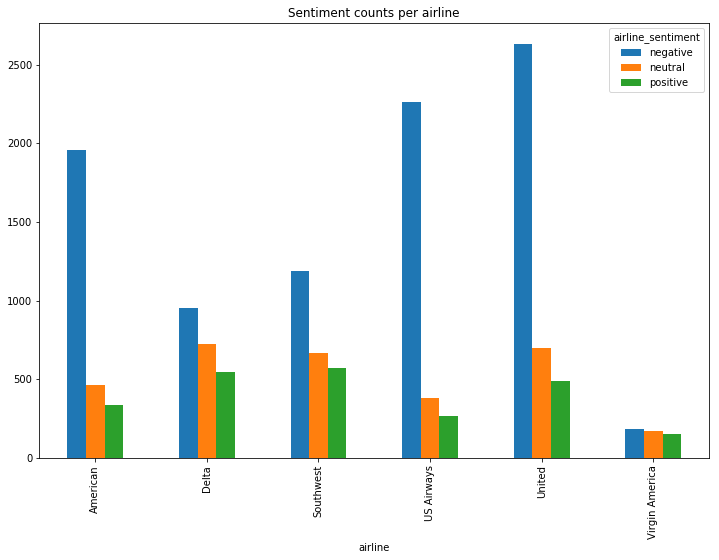

In [55]:
dfac = raw_data[['airline', 'airline_sentiment']]
dfac = dfac.groupby(['airline', 'airline_sentiment']).size()
dfac = dfac.unstack()
dfac.plot.bar(title='Sentiment counts per airline', figsize=(12,8))

We see that the distribution is not the same; some airlines are heavily biased towards negative tweets. Besides, we know that the airlines handlers are present at the beginning of almost all the tweets. This will lead me to remove them in order to avoid the classifiers to learn from a strong, false signal (the airline handler instead of the text sentiment itself).

## Text pre-processing

The other "classic" techniques that I will use as baseline normally require a more involved pre-processing:
- All the tweets have a handler with the airline's company at the beginning (e.g. `@VirginAmerica`), I am removing them as they bring no additional information and actually could make the models to overfit, learning to classify according to the airline's name instead of the actual sentiment of the text.

- `nltk` has a very handy `TweetTokenizer` ([documentation](https://www.nltk.org/api/nltk.tokenize.html)) that helps to clean up HTML tags and to respect/normalize emojis.
- We remove English stopwords and most punctuation marks, except a few that convey semantic meaning.
- Originally this used stemming, but we can also leverage lemmatization from NLTK at a very small cost, and it should in theory offer better quality results.
- Any hashtag that looks like a word (e.g. `#angry`) has the initial `#` removed, since they normally carry regular meaning.
- All URLs are replaced by `xxurl`.
- All numbers ar replaced by `xxnum`.

In [5]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import nltk

REGEX_URL = re.compile(r'https?://|www.')
REGEX_NUM = re.compile(r'[0-9.-]?[0-9][0-9.-]?')

TOKEN_URL = 'xxurl'
TOKEN_NUM = 'xxnum'

STOPWORDS_EN = set(stopwords.words('english') + ["i've"])
STOP_PUNCT = set('."\'&”“’,:;/*()[]{}@#')

def normalize_token(token):
    for regex, marker in [(REGEX_URL, TOKEN_URL), (REGEX_NUM, TOKEN_NUM)]:
        if re.match(regex, token):
            return marker
    return token

def get_wordnet_pos(pos):
    """Map POS tag to first character lemmatize() accepts"""
    tag = pos[0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def normalize_text(text, remove_stopwords=True, use_lemmatizer=False, remove_prefixes=True):
    tokenizer = TweetTokenizer(preserve_case=False)
    lemmatizer = WordNetLemmatizer()
    
    def is_stop_token(t):
        return len(t) == 0 or t in STOP_PUNCT or remove_stopwords and t in STOPWORDS_EN
    
    tokens = tokenizer.tokenize(text)
    
    # if the first token is a handler, it's normally irrelevant
    if tokens[0].startswith('@'):
        tokens.pop(0)

    ntokens = []
    
    # STEP 1: cleanup, formatting
    for token in tokens:
        ntoken = normalize_token(token)
        
        if remove_prefixes and any(token.startswith(c) for c in ['@', '#']):
            ntoken = ntoken[1:]
        if not use_lemmatizer and is_stop_token(ntoken):
            continue

        ntokens.append(ntoken)
        
    if not use_lemmatizer:
        return ' '.join(ntokens)
    
    ltokens = []
    
    # STEP 2: NLP tagging
    pos_tags = nltk.pos_tag(ntokens)

    # STEP 3: "semantic" cleaning
    for token, pos in pos_tags:
        if is_stop_token(token):
            continue
        if pos == 'CD':
            ltoken = TOKEN_NUM
        else:
            ltoken = lemmatizer.lemmatize(token, get_wordnet_pos(pos))
        ltokens.append(ltoken)
           
    return ' '.join(ltokens)

In [6]:
def show_normalization(_df):
    for i, row in _df.iterrows():
        print(row.sentiment.upper() + ": " + row.text + '\n>> ' + normalize_text(row.text) + '\n')

show_normalization(df.head(10))

NEUTRAL: @VirginAmerica What @dhepburn said.
>> dhepburn said

POSITIVE: @VirginAmerica plus you've added commercials to the experience... tacky.
>> plus added commercials experience ... tacky

NEUTRAL: @VirginAmerica I didn't today... Must mean I need to take another trip!
>> today ... must mean need take another trip !

NEGATIVE: @VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse
>> really aggressive blast obnoxious entertainment guests faces little recourse

NEGATIVE: @VirginAmerica and it's a really big bad thing about it
>> really big bad thing

NEGATIVE: @VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.
it's really the only bad thing about flying VA
>> seriously would pay $ xxnum flight seats playing really bad thing flying va

POSITIVE: @VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)
>> yes nearly every time fly vx ear worm go away :)

So we add a new column to the dataset with the normalized texts.

In [7]:
# apply normalization to ALL text
df['norm_text'] = df.text.apply(normalize_text)
df.head(20)

,text,sentiment,norm_text
0,@VirginAmerica What @dhepburn said.,neutral,dhepburn said
1,@VirginAmerica plus you've added commercials t...,positive,plus added commercials experience ... tacky
2,@VirginAmerica I didn't today... Must mean I n...,neutral,today ... must mean need take another trip !
3,@VirginAmerica it's really aggressive to blast...,negative,really aggressive blast obnoxious entertainmen...
4,@VirginAmerica and it's a really big bad thing...,negative,really big bad thing
5,@VirginAmerica seriously would pay $30 a fligh...,negative,seriously would pay $ xxnum flight seats playi...
6,"@VirginAmerica yes, nearly every time I fly VX...",positive,yes nearly every time fly vx ear worm go away :)
7,@VirginAmerica Really missed a prime opportuni...,neutral,really missed prime opportunity men without ha...
8,"@virginamerica Well, I didn't…but NOW I DO! :-D",positive,well … ! :-D
9,"@VirginAmerica it was amazing, and arrived an ...",positive,amazing arrived hour early good


Let's actually check the distribution of tokens grouped by the sentiment of the tweet. Since we have already normalized them and done a lot of cleanup (like removing stopwords, etc.) this should be quite easy now.

In [66]:
SENTIMENTS = ['positive', 'neutral', 'negative']
token_counters = {sent: Counter() for sent in SENTIMENTS}
for _, row in df.iterrows():
    tokens = row['norm_text'].split(' ')
    token_counters[row['sentiment']].update(tokens)

In [95]:
mct = [[(s.upper(), '')] + token_counters[s].most_common(25) for s in SENTIMENTS]
for i in range(len(mct[0])):
    row = ['%-15s%5s' % c[i] for c in mct]
    print('\t\t'.join(row))

POSITIVE            		NEUTRAL             		NEGATIVE            
!               1947		?               1385		xxnum           5102
thanks           610		xxnum           1075		?               3106
thank            453		!                647		flight          2925
xxnum            414		flight           609		!               2486
flight           377		xxurl            526		get              988
great            236		-                244		cancelled        925
xxurl            233		get              238		...              747
service          162		please           181		service          744
love             136		...              179		hours            649
-                125		flights          169		help             617
?                117		help             167		hold             611
customer         114		need             164		customer         608
get              114		thanks           156		time             588
guys             110		jetblue          146		-                584
much             109		wou

It will be important to remember these when we study the impact of individual words in the sentiment of the sentence. This observation also hints that a classifier that relies on just word distributions (li 

In [8]:
df_binary = df[df.sentiment != 'neutral']
print("Size of the dataset with only pos/neg: " + str(df_binary.shape))
df_binary.head()

Size of the dataset with only pos/neg: (11541, 3)


,text,sentiment,norm_text
1,@VirginAmerica plus you've added commercials t...,positive,plus added commercials experience ... tacky
3,@VirginAmerica it's really aggressive to blast...,negative,really aggressive blast obnoxious entertainmen...
4,@VirginAmerica and it's a really big bad thing...,negative,really big bad thing
5,@VirginAmerica seriously would pay $30 a fligh...,negative,seriously would pay $ xxnum flight seats playi...
6,"@VirginAmerica yes, nearly every time I fly VX...",positive,yes nearly every time fly vx ear worm go away :)


For the training of all the examples, we will split 10% of the data for the validation (test) set.

In [9]:
from sklearn.model_selection import train_test_split

text_train, text_test, label_train, label_test = train_test_split(df_binary['norm_text'], df_binary['sentiment'], test_size=0.1, random_state=0)

print("Training size: %d; test size: %d" % (len(text_train), len(text_test)))

Training size: 10386; test size: 1155


Some preparation for smaller representation of the labels:

In [10]:
LABELS = {'positive': 1, 'neutral': 0, 'negative': -1}

y_train = [LABELS[l] for l in label_train]
y_test = [LABELS[l] for l in label_test]

We will store the performance of all the classifiers here:

In [11]:
# key : (train score, test score)
results = {}

def add_result(*args):
    results[args[0]] = args[1:]
    print(args)

### Dummy classifier

As an absolute baseline, let's check the accuracy of a classifier that just outputs random predictions based on the training set's class distribution.

In [12]:
from sklearn.dummy import DummyClassifier

clf = DummyClassifier(strategy='stratified', random_state=42)
clf.fit(text_train, y_train)

score_train = clf.score(text_train, y_train)
score_test = clf.score(text_test, y_test)

add_result('random_with_class_dist', score_train, score_test)

('random_with_class_dist', 0.6746581937223185, 0.6588744588744588)


### Multinomian Naive Bayes using counts

For the first approach, we use directly the word counts as features, and feed them into a multinomial Naive Bayes classifier from `sklearn`.

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

counter = CountVectorizer()
X_train = counter.fit_transform(text_train)
X_test = counter.transform(text_test)

In [14]:
print("Size of the training set with word counts as features (num_samples, num_features): " + str(X_train.shape))

Size of the training set with word counts as features (num_samples, num_features): (10386, 10201)


In [15]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB(alpha=1.0)
clf.fit(X_train, y_train)

score_train = clf.score(X_train, y_train)
score_test = clf.score(X_test, y_test)

add_result('nb_multi_counts', score_train, score_test)

('nb_multi_counts', 0.9433853264009243, 0.9038961038961039)


### Gaussian NB using TF-IDF, direct

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words='english')
v_train = vectorizer.fit_transform(text_train)
v_test = vectorizer.transform(text_test)

X_train = v_train.toarray()
X_test = v_test.toarray()

print("Size of the training set with TF-IDF vectorization (num_samples, num_features): " + str(X_train.shape))

Size of the training set with TF-IDF vectorization (num_samples, num_features): (10386, 9981)


In [17]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
clf.fit(X_train, y_train)

score_train = clf.score(X_train, y_train)
score_test = clf.score(X_test, y_test)

add_result('nb_gaussian_tf_idf', score_train, score_test)

('nb_gaussian_tf_idf', 0.8290968611592529, 0.6874458874458874)


### Gaussian NB using TF-IDF and feature selection

In [18]:
from sklearn.feature_selection import SelectPercentile, f_classif

selector = SelectPercentile(f_classif, percentile=10)
selector.fit(v_train, y_train)
vs_train = selector.transform(v_train)
vs_test  = selector.transform(v_test)

X_train = vs_train.toarray()
X_test = vs_test.toarray()

print("Size of the training set with TF-IDF vectorization and feature selection (num_samples, num_features): " + str(X_train.shape))

Size of the training set with TF-IDF vectorization and feature selection (num_samples, num_features): (10386, 998)


In [19]:
clf = GaussianNB()
clf.fit(X_train, y_train)

score_train = clf.score(X_train, y_train)
score_test = clf.score(X_test, y_test)

add_result('nb_gaussian_tf_idf_feature_sel', score_train, score_test)

('nb_gaussian_tf_idf_feature_sel', 0.865106874638937, 0.8112554112554112)


### SVM

In [22]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# we try different values of C and kernel
parameters = {
    'kernel': ('linear', 'rbf'),
    'C': [1.0, 10.0, 100.0]
}

svc = SVC(gamma='auto') # setting gamma=auto to avoid warning
clf = GridSearchCV(svc, parameters, cv=3, return_train_score=True)
clf.fit(X_train, y_train)

# get the best and put it in the results
score_train = clf.cv_results_['mean_train_score'][clf.best_index_]
score_test = clf.cv_results_['mean_test_score'][clf.best_index_]
print("SVC would use these best parameters: %s, train score=%f, test score=%f" % (clf.best_params_, score_train, score_test))
add_result('SVC_%s_%.1f' % (clf.best_params_['kernel'], clf.best_params_['C']), score_train, score_test)

SVC would use these best parameters: {'C': 10.0, 'kernel': 'linear'}, train score=0.951906, test score=0.914982
('SVC_linear_10.0', 0.951906488272142, 0.9149817061428847)


In [23]:
svc_df = pd.DataFrame(clf.cv_results_)[['param_kernel', 'param_C', 'mean_train_score', 'mean_test_score', 'mean_fit_time', 'mean_score_time']]
svc_df

,param_kernel,param_C,mean_train_score,mean_test_score,mean_fit_time,mean_score_time
0,linear,1,0.921240,0.903235,25.123315,9.672832
1,rbf,1,0.794724,0.794724,33.335429,13.849491
2,linear,10,0.951906,0.914982,20.304209,7.031278
3,rbf,10,0.813980,0.813595,34.113281,13.956996
4,linear,100,0.957395,0.912767,22.295236,5.947098
5,rbf,100,0.877431,0.871750,29.860306,12.008685


### Decision Tree

In [24]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(min_samples_split=40)

clf.fit(X_train, y_train)

score_train = clf.score(X_train, y_train)
score_test = clf.score(X_test, y_test)

add_result('dtree', score_train, score_test)

('dtree', 0.952050837666089, 0.8805194805194805)


## Collecting all results

In [25]:
results_df = pd.DataFrame([(k, *v) for k, v in results.items()], columns=['method', 'score_train', 'score_test'])
results_df

,method,score_train,score_test
0,random_with_class_dist,0.674658,0.658874
1,nb_multi_counts,0.943385,0.903896
2,nb_gaussian_tf_idf,0.829097,0.687446
3,nb_gaussian_tf_idf_feature_sel,0.865107,0.811255
4,SVC_linear_10.0,0.951906,0.914982
5,dtree,0.952051,0.880519


In [26]:
import pickle

with open('data/results.pkl', 'wb') as f:
    pickle.dump(results, f)